In [1]:
import jax
import os

In [2]:
from sklearn import datasets
import scanpy as sc
import optax
import matplotlib.pyplot as plt
from sklearn import preprocessing as pp
import numpy as np
import scipy

import ott
import sklearn
import matplotlib.pyplot as plt
from ott.geometry import geometry, pointcloud
import jax
from typing import Mapping, Any, Optional, Union, Callable, Tuple
from types import MappingProxyType
import jax.numpy as jnp
from functools import partial
from ott.solvers.linear import sinkhorn
from ott.problems.linear import linear_problem
from entot.models.model import OTFlowMatching
from entot.nets.nets import MLP_vector_field, MLP_bridge, MLP_marginal,MLP_fused_vector_field
import sklearn.preprocessing as pp
import scanpy as sc
from ott.solvers.linear import sinkhorn, acceleration
from sklearn import preprocessing as pp

/home/icb/dominik.klein/mambaforge/envs/entot_pip/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
/home/icb/dominik.klein/mambaforge/envs/entot_pip/lib/python3.11/site-packages/equinox/_ad.py:753: UserWarning: As of Equinox 0.10.7, `equinox.filter_custom_vjp.defvjp` is deprecated in favour of `.def_fwd` and `.def_bwd`. This new API supports symbolic zeros, which allow for more efficient autodifferentiation rules. In particular:
- the fwd and bwd functions take an extra `perturbed` argument, which     indicates which primals actually need a gradient. You can use this     to skip computing the gradient for any unperturbed value. (You can     also safely just ignore this if you wish.)
- `None` was previously passed to indicate a symbolic zero gradient for     all objects that weren't inexact arrays, but al

In [3]:
adata_atac = sc.read("../../data/bone_marrow_atac.h5ad")
adata_rna = sc.read("../../data/bone_marrow_rna.h5ad")

/home/icb/dominik.klein/mambaforge/envs/entot_pip/lib/python3.11/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(
/home/icb/dominik.klein/mambaforge/envs/entot_pip/lib/python3.11/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


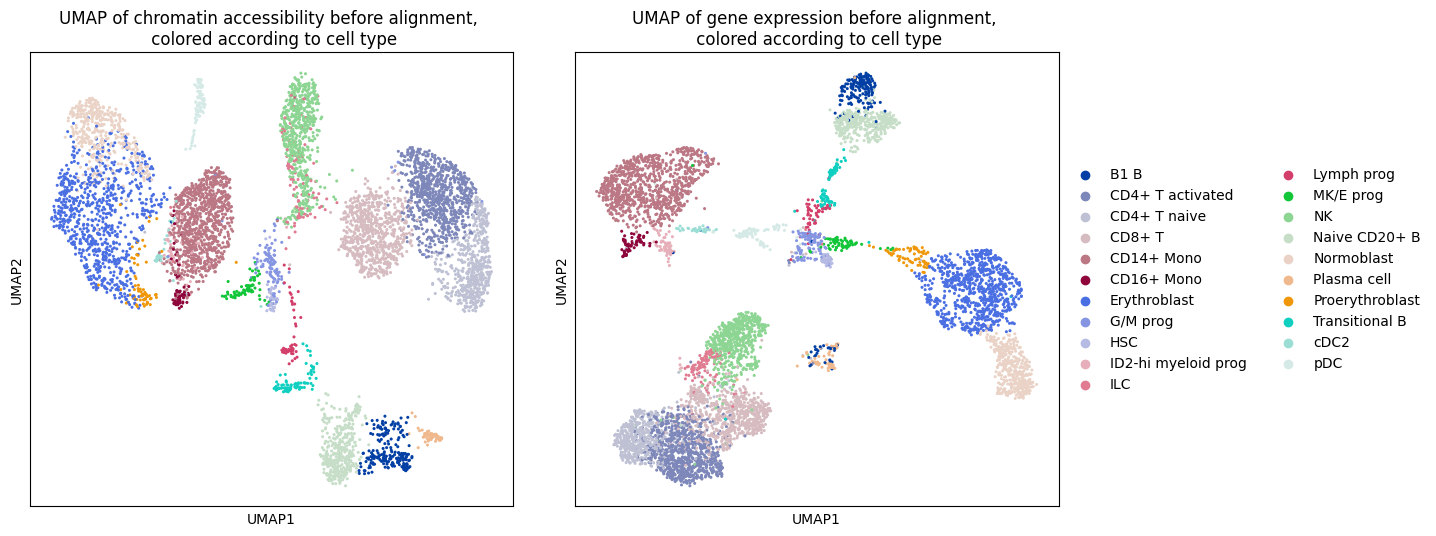

In [4]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))
sc.pl.umap(adata_atac, color="cell_type", ax=ax1, show=False)
ax1.legend().remove()
ax1.set_title(
    "UMAP of chromatin accessibility before alignment, \n colored according to cell type"
)
sc.pl.umap(adata_rna, color="cell_type", ax=ax2, show=False)
ax2.set_title(
    "UMAP of gene expression before alignment, \n colored according to cell type"
)
plt.tight_layout(pad=3.0)
plt.show()

In [5]:
adata_source=adata_atac.copy()
adata_target=adata_rna.copy()

n_cells_source=len(adata_atac)

n_samples_train = int(n_cells_source * 0.6)
n_samples_test = n_cells_source - n_cells_source

inds_train = np.asarray(jax.random.choice(jax.random.PRNGKey(0), n_cells_source, (n_samples_train,), replace=False))
inds_test = list(set(list(range(n_cells_source))) - set(np.asarray(inds_train)))

fused = np.concatenate((adata_atac.obsm["geneactivity_scvi"], adata_rna.obsm["geneactivity_scvi"]), axis=0)
fused = sc.pp.pca(fused, n_comps=25)

source_fused = fused[:len(adata_source), :]
target_fused = fused[len(adata_target):, :]

source_q = pp.normalize(
    adata_source.obsm["ATAC_lsi_red"], norm="l2"
) 
target_q = adata_target.obsm["GEX_X_pca"]

source_train_q = source_q[inds_train, :]
source_test_q = source_q[inds_test, :]
target_train_q = target_q[inds_train, :]
target_test_q = target_q[inds_test, :]
source_train_fused = source_fused[inds_train, :]
source_test_fused = source_fused[inds_test, :]
target_train_fused = target_fused[inds_train, :]
target_test_fused = target_fused[inds_test, :]

source_train = np.concatenate((source_train_fused, source_train_q), axis=1)
source_test = np.concatenate((source_test_fused, source_test_q), axis=1)
target_train = np.concatenate((target_train_fused, target_train_q), axis=1)
target_test = np.concatenate((target_test_fused, target_test_q), axis=1)

adata_source_train = adata_source[inds_train,:]
adata_source_test = adata_source[inds_test,:]

adata_target_train = adata_target[inds_train,:]
adata_target_test = adata_target[inds_test,:]

In [6]:
adata_source_train.obsm["emb"] = source_train
adata_source_test.obsm["emb"] = source_test
adata_target_train.obsm["emb"] = target_train
adata_target_test.obsm["emb"] = target_test

adata_source_train.obsm["emb_q"] = source_train_q
adata_source_test.obsm["emb_q"] = source_test_q
adata_target_train.obsm["emb_q"] = target_train_q
adata_target_test.obsm["emb_q"] = target_test_q

adata_source_train.obsm["emb_fused"] = source_train_fused
adata_source_test.obsm["emb_fused"] = source_test_fused
adata_target_train.obsm["emb_fused"] = target_train_fused
adata_target_test.obsm["emb_fused"] = target_test_fused

In [7]:
neural_net = MLP_vector_field(target_train.shape[1], latent_embed_dim = 256, num_layers=8, n_frequencies=128)
bridge_net = MLP_bridge(target_train.shape[1], 10)
linear_ot_solver = sinkhorn.Sinkhorn(
                momentum=acceleration.Momentum(value=1., start=25)
        )
solver = ott.solvers.quadratic.gromov_wasserstein.GromovWasserstein(epsilon=10**8, linear_ot_solver=linear_ot_solver)

otfm = OTFlowMatching(neural_net, bridge_net, epsilon=None, scale_cost="mean", input_dim=source_train.shape[1], output_dim=target_train.shape[1], iterations=20_000, ot_solver=solver, k_noise_per_x=1, fused_penalty = 1.0, split_dim=fused.shape[1])

In [8]:
otfm(source_train, target_train, 1024, 1024)

100%|██████████| 20000/20000 [05:06<00:00, 65.36it/s]


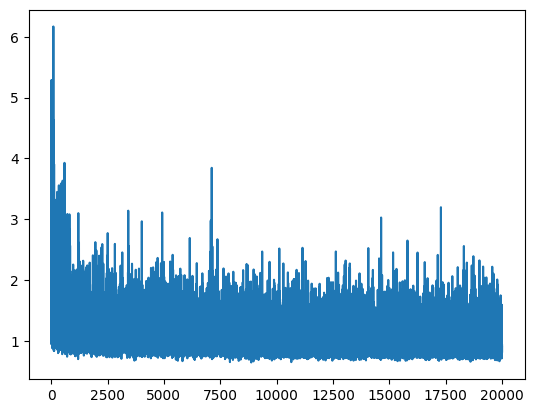

In [9]:
plt.plot(np.arange(len(otfm.metrics["loss"])), otfm.metrics["loss"])

In [10]:
def foscttm(
    x: np.ndarray,
    y: np.ndarray,
) -> float:
    d = scipy.spatial.distance_matrix(x, y)
    foscttm_x = (d < np.expand_dims(np.diag(d), axis=1)).mean(axis=1)
    foscttm_y = (d < np.expand_dims(np.diag(d), axis=0)).mean(axis=0)
    fracs = []
    for i in range(len(foscttm_x)):
        fracs.append((foscttm_x[i] + foscttm_y[i]) / 2)
    return np.mean(fracs).round(4)

In [11]:
res_train = [None] * 1
res_test = [None] * 1

for i in range(1):
    res_train[i] = otfm.transport(source_train, seed=i)[0][0,...]
    res_test[i] = otfm.transport(source_test, seed=i)[0][0,...]

In [12]:
cond_mean_train = jnp.mean(jnp.asarray(res_train), axis=0)
cond_mean_test = jnp.mean(jnp.asarray(res_test), axis=0)

In [13]:
foscttm(res_train[0], target_train)

0.4959

In [14]:
foscttm(res_test[0], target_test)

0.5047

In [15]:
foscttm(cond_mean_train, target_train)

0.4959

In [16]:
foscttm(cond_mean_test, target_test)

0.5047

/home/icb/dominik.klein/mambaforge/envs/entot_pip/lib/python3.11/site-packages/anndata/_core/anndata.py:1838: UserWarning: Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
  utils.warn_names_duplicates("obs")
/home/icb/dominik.klein/mambaforge/envs/entot_pip/lib/python3.11/site-packages/umap/distances.py:1063: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  @numba.jit()
/home/icb/dominik.klein/mambaforge/envs/entot_pip/lib/python3.11/site-packages/umap/distances.py:1071: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, bu

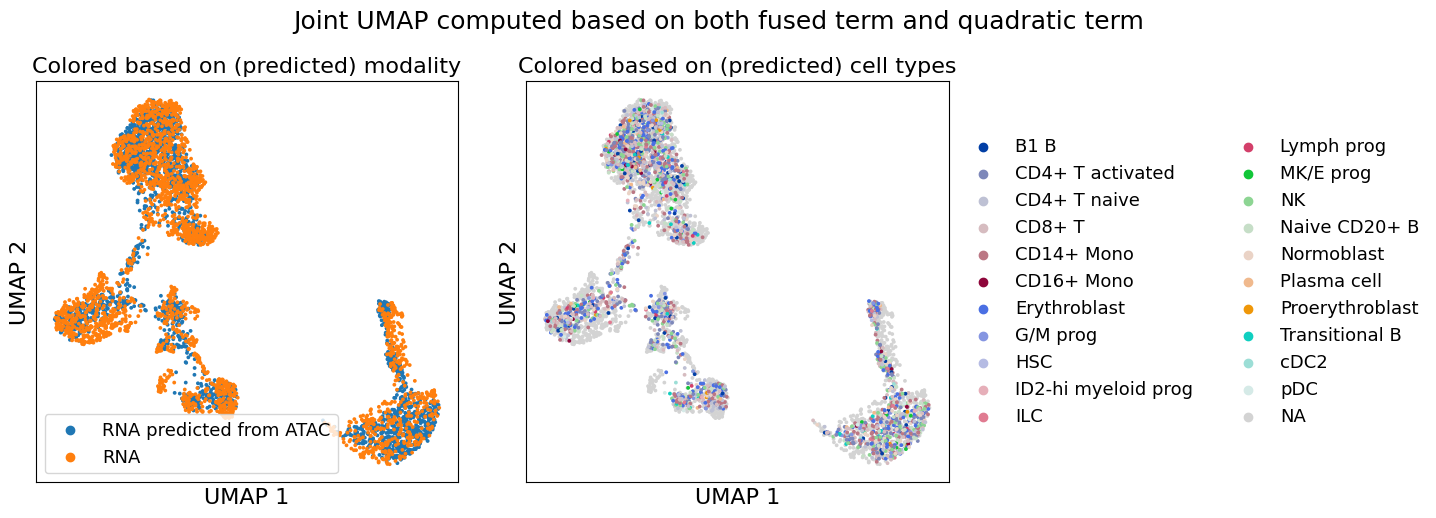

In [18]:
adata_one_sample = sc.concat(
    [adata_source_test, adata_target_test],
    join="outer",
    label="batch",
    keys=["RNA predicted from ATAC", "RNA"],
)
adata_one_sample.obsm["X_translated_0"] = np.concatenate(
    (res_test[0], target_test), axis=0
)
sc.pp.neighbors(adata_one_sample, use_rep="X_translated_0")
sc.tl.umap(adata_one_sample)

def adapt_cell_type(x):
    if x["batch"] == "RNA":
        return np.nan
    return x["cell_type"]
adata_one_sample.obs["predicted_cell_type_only"] = adata_one_sample.obs.apply(adapt_cell_type, axis=1)

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))
fig.suptitle("Joint UMAP computed based on both fused term and quadratic term", size=18, y=0.9)
sc.pl.umap(adata_one_sample, color=["batch"], ax=ax1, show=False, size=30, legend_fontsize=10)
ax1.legend()
ax1.set_title("Colored based on (predicted) modality", fontsize=16)
ax1.set_xlabel('UMAP 1', fontsize=16)
ax1.set_ylabel('UMAP 2', fontsize=16)
sc.pl.umap(adata_one_sample, color=["predicted_cell_type_only"], ax=ax2, show=False, size=30, legend_fontsize=13)
ax2.set_title("Colored based on (predicted) cell types", fontsize=16)
ax2.set_xlabel('UMAP 1', fontsize=16)
ax2.set_ylabel('UMAP 2', fontsize=16)
ax1.legend(fontsize=13)
plt.tight_layout(pad=3.0)
plt.show()

In [19]:
def adapt_cell_type(x):
    if x["batch"] == "RNA":
        return np.nan
    return x["cell_type"]
adata_one_sample.obs["predicted_cell_type_only"] = adata_one_sample.obs.apply(adapt_cell_type, axis=1)

/home/icb/dominik.klein/mambaforge/envs/entot_pip/lib/python3.11/site-packages/anndata/_core/anndata.py:1230: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  df[key] = c
/home/icb/dominik.klein/mambaforge/envs/entot_pip/lib/python3.11/site-packages/anndata/_core/anndata.py:1838: UserWarning: Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
  utils.warn_names_duplicates("obs")
/home/icb/dominik.klein/mambaforge/envs/entot_pip/lib/python3.11/site-packages/anndata/_core/anndata.py:1838: UserWarning: Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
  utils.warn_names_duplicates("obs")
/home/icb/dominik.klein/mambaforge/envs/entot_pip/lib/python3.11/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(
/home/icb/dominik.klein/mambaforge/envs/entot_pip/lib

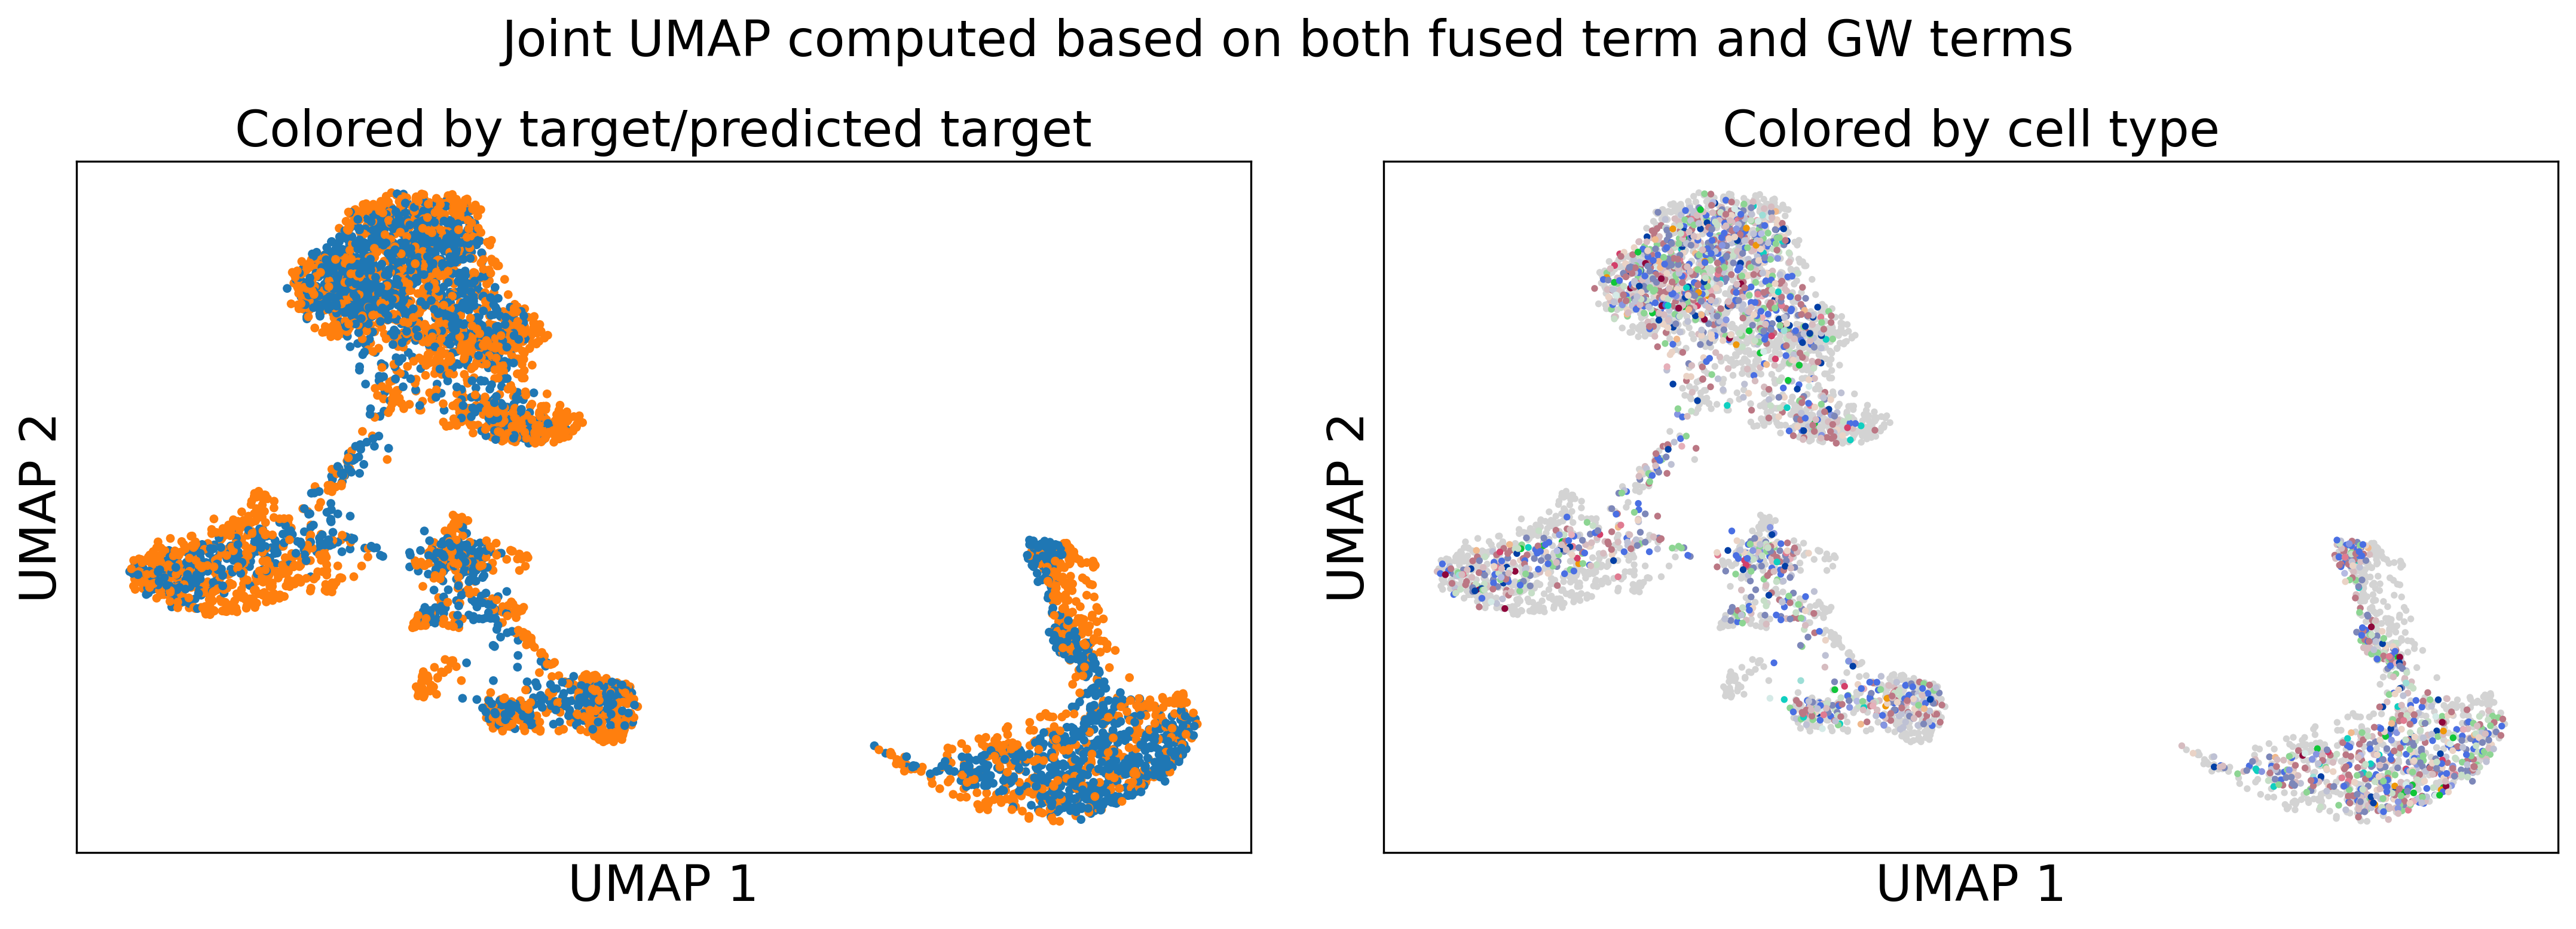

In [20]:
np.random.seed(0)
random_indices=np.random.permutation(list(range(adata_one_sample.shape[0])))

sc.pp.neighbors(adata_one_sample, use_rep="X_translated_0")
sc.tl.umap(adata_one_sample)
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6), dpi=300)
fig.suptitle("Joint UMAP computed based on both fused term and GW terms", size=20, y=0.9)
sc.pl.umap(adata_one_sample[random_indices,:], color=["batch"], ax=ax1, show=False, size=50, legend_fontsize=10)
ax1.legend()
ax1.set_title("Colored by target/predicted target", fontsize=20)
ax1.set_xlabel('UMAP 1', fontsize=20)
ax1.set_ylabel('UMAP 2', fontsize=20)
sc.pl.umap(adata_one_sample, color=["predicted_cell_type_only"], ax=ax2, show=False, size=30, legend_fontsize=13)
ax2.set_title("Colored by cell type", fontsize=20)
ax2.set_xlabel('UMAP 1', fontsize=20)
ax2.set_ylabel('UMAP 2', fontsize=20)

ax1.get_legend().remove()
ax2.get_legend().remove()
plt.tight_layout(pad=3.0)
plt.show()

In [21]:
adata_one_sample.write("outer_coupling.h5ad")